In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import json
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
from pymongo import MongoClient

# Remember to connect to VPN first 
DATABASE_URL = "internal-mongo-elb-624130134.us-east-1.elb.amazonaws.com"
USER, PWD = 'analyzer', 'hyperpilot'
METRIC_DB, CONFIG_DB = 'metricdb', 'configdb'

In [2]:
# Utilities
def find_all(collection, filt={}, proj=None, database=METRIC_DB, return_list=False):
    """ A wrapper for 'find' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            documents = db[collection].find(filt, proj)
        else:
            documents = db[collection].find(filt)
    except Exception as e:
        raise e
    else:
        return documents if not return_list else list(documents)
    finally:
        client.close()


def find_one(collection, filt, proj=None, database=METRIC_DB):
    """ A wrapper for 'findOne' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            document = db[collection].find_one(filt, proj)
        else:
            document = db[collection].find_one(filt)
    except Exception as e:
        raise e
    else:
        return document
    finally:
        client.close()

In [3]:
def create_application_dataframe():
    app_objs = find_all(collection='applications', database=CONFIG_DB, return_list=True)
    data, columns = [], ['name', 'sloMetric', 'sloValue', 'sloType']
    for i in app_objs:
        data.append([i['name'], i['slo']['metric'], i['slo']['value'], i['slo']['type']])
    return pd.DataFrame(data, columns=columns)

In [4]:
def create_calibration_dataframe():
    cali_objs = find_all(collection='calibration', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in cali_objs]
    union_keys = reduce(set.intersection, keys)
    union_keys.remove('testResult')

    for cali_obj in cali_objs:
        tmp_df = pd.read_json(json.dumps(cali_obj['testResult']))
        for i in union_keys:            
            tmp_df[i] = np.array(cali_obj[i]).squeeze()
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    return df

In [5]:
def create_profiling_dataframe():
    prof_objs = find_all(collection='profiling', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in prof_objs]
    union_keys = reduce(set.intersection, keys)
    union_keys.remove('testResult')
    union_keys.remove('benchmarks')
    union_keys.remove('services')
    
    for prof_obj in prof_objs:
        tmp_df = pd.DataFrame([pd.Series(i) for i in prof_obj['testResult']])
        if 'toleratedInterference' in tmp_df.columns:
            del tmp_df['toleratedInterference']
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        for i in union_keys:
            tmp_df[i] = np.array(prof_obj[i]).squeeze()
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    df['appNameCap'] = df['appName'] + df['appCapacity'].map(lambda x : '-cap:'+str(x))
    
    return df


In [6]:
def computeToleratedInterference(benchmarks, sloMetric, metricType, tolerancePercentage=10.):
    """ Compute Tolerated Interference. 
    Assuming monotomicity in between each benchmarks interval. 
    Args: 
        benchmarks(DataFrame): index=loadIntensity and columns=['qosValue']
        sloMetric(float): service level objective for the application
        metricType(str): 'throughput', 'latency'
        tolerancePercentage(float): percentage of slo tolerance
    Return:
        ti(float): tolerated interference.
    """
    def _linearIntp((x1,y1), (x2,y2), y3):
        if y1 > y2:
            return _linearIntp((x2,y2),(x1,y1), y3)
        if y3 < y1 or y3 > y2:
            return None
        else:
            return (y3-y1)*(x2-x1)/(y2-y1)+x1
        
    intensities, sloValues = np.append(0, benchmarks.index.values), np.append(sloMetric, benchmarks.values)
    candidates = []
    
    # check metric type
    if metricType == 'throughput':
        toleratedSloMetric = sloMetric * (1.-tolerancePercentage/100.)
        if min(sloValues) > toleratedSloMetric:
            candidates.append(100.)
    elif metricType == 'latency':
        toleratedSloMetric = sloMetric * (1.+tolerancePercentage/100.)
        if max(sloValues) < toleratedSloMetric:
            candidates.append(100.)
    else:
        assert False, 'invalid metric type'
    print 'type: {}'.format(metricType), 'toleratedMetric: {}'.format(toleratedSloMetric)

    # check input data
    assert (sorted(intensities) == intensities).all(), 'intensities are not monotonic. intensities: {}'.format(intensities)
    assert all(intensity >= 0 and intensity <= 100 for intensity in intensities), 'invalid intensities. intensites: {}'.format(intensities)
    assert len(sloValues) == len(intensities), 'length of sloValues and intensities does not match. sloValues: {}, intensities: {}'.format(sloValues, intensities)

    for i in range(len(sloValues)-1): # edge case tested
        x = _linearIntp((intensities[i], sloValues[i]), (intensities[i+1], sloValues[i+1]), toleratedSloMetric)
        if x:
            candidates.append(x)
    
    return sorted(candidates)

### configdb.application

In [7]:
app_df = create_application_dataframe()
app_df

,name,sloMetric,sloValue,sloType
0,redis,GET,35000,throughput
1,mongo,Insert.Empty,5000,throughput
2,mysql,GET,35000,throughput
3,kafka,99thLatency,200,latency
4,nginx,95,300,throughput


### metricdb.calibration

In [8]:
cali_df = create_calibration_dataframe()
cali_df['appNameCap']=cali_df['appName'].map(lambda x: str(x)+'_')+cali_df['finalIntensity'].map(str)
cali_df.head(3)

,loadIntensity,qosValue,appName,qosMetrics,loadTester,testDuration,testId,_id,finalIntensity,appNameCap
0,5,20069.0,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0,redis_41.0
1,5,20578.0,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0,redis_41.0
2,5,19916.0,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0,redis_41.0


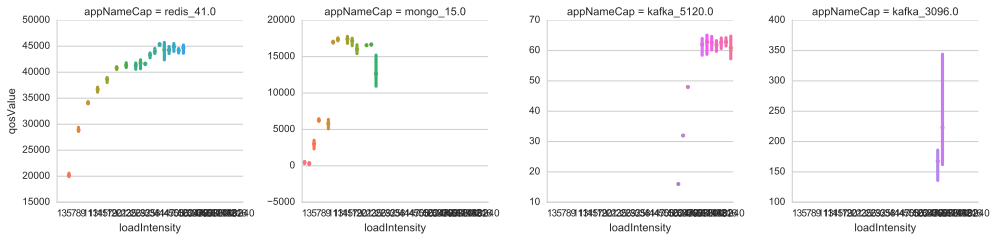

In [9]:
g = sns.factorplot(x="loadIntensity", y="qosValue", col='appNameCap', hue=None, data=cali_df,
                   palette="husl", ci=100, sharex=False, sharey=False, scale=0.4, alpha=0.1, size=3.5)

### metricdb.profiling

In [10]:
prof_df = create_profiling_dataframe()
prof_df.head(3)

,benchmark,loadIntensity,qosValue,serviceInTest,appName,testDuration,sloTolerance,numServices,appCapacity,loadTester,testId,serviceNode,_id,sloMetric,appNameCap
0,cpu,25,47323.84,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
1,cpu,50,48419.12,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
2,cpu,75,42678.50,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0


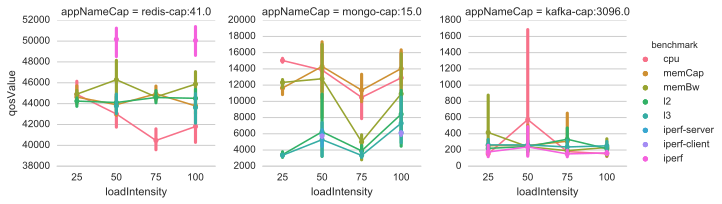

In [11]:
g = sns.factorplot(x="loadIntensity", y="qosValue", col='appNameCap', hue='benchmark', data=prof_df,
                   palette="husl", ci=100, sharex=True, sharey=False, scale=0.5, alpha=0.1, size=3)
g.despine(left=True)

### Inspect each appName individually

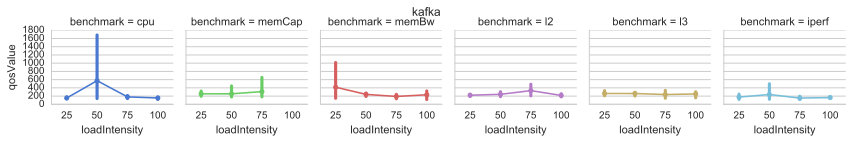

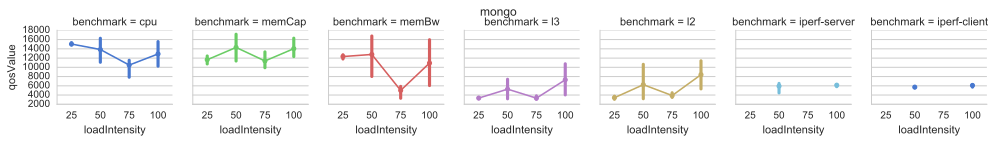

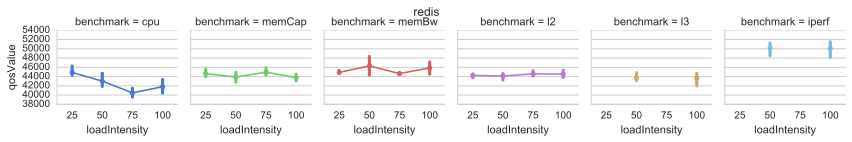

In [12]:
for appName, df in prof_df.groupby('appName'):
    g = sns.factorplot(x="loadIntensity", y="qosValue", col="benchmark", hue="benchmark", data=df, ci=100, palette="muted", size=2, scale=0.5,
               scatter_kws={"s": 50, "alpha": 1})
    g.fig.suptitle(appName)


In [13]:
# Currently only kafka has the correct data schema.
valid_prof_dfs = prof_df[prof_df['appName'] == 'kafka'] 
valid_prof_dfs = [df for (appCap, df) in valid_prof_dfs.groupby('appCapacity')]

# Retrieve finalResult from application
for df in valid_prof_dfs:
    finalResult = find_one(collection='calibration', filt={'appName':'kafka', 'finalIntensity': df['appCapacity'].values[0]}, proj={'finalResult':1})
    qosValue = finalResult['finalResult']['qosValue']
    print qosValue 
    
df = valid_prof_dfs[0] # pick one

feature_names = list(set(df['benchmark'].values))
feature_names

167.666667


[u'memCap', u'l2', u'l3', u'iperf', u'memBw', u'cpu']

### Generate radar plot

In [14]:
# computeToleratedInterference Test data
APP = 'kafka'
sloValue = app_df[app_df['name'] == APP]['sloValue'].values[0]
test_data = [j for (appNameCap, j) in prof_df.groupby('appNameCap') if APP in appNameCap] # only kafka has correct data now
test_data = test_data[0]

print 'sloValue: {}'.format(sloValue)
radar_data = {}
radar_data['benchmark'] = []
radar_data['tolerated_interference'] = []
for benchmark, df in test_data.groupby(['benchmark', 'loadIntensity'])['qosValue'].agg("mean").groupby(level=0):
    df.index = df.index.droplevel(level=0)
    print benchmark, df
    result = computeToleratedInterference(df, sloValue, metricType='latency')
    print result
    radar_data['benchmark'].append(benchmark)
    radar_data['tolerated_interference'].append(min(result))
    

sloValue: 200
cpu loadIntensity
25     153.0
50     574.8
75     180.6
100    154.4
Name: qosValue, dtype: float64
type: latency toleratedMetric: 220.0
[28.971076339497394, 72.501268391679346]
iperf loadIntensity
25     175.8
50     238.0
75     152.0
100    163.8
Name: qosValue, dtype: float64
type: latency toleratedMetric: 220.0
[42.765273311897118, 55.232558139534873]
l2 loadIntensity
25     220.6
50     243.0
75     332.8
100    216.2
Name: qosValue, dtype: float64
type: latency toleratedMetric: 220.0
[24.271844660194215, 99.185248713550592]
l3 loadIntensity
25     263.2
50     262.4
75     237.6
100    251.8
Name: qosValue, dtype: float64
type: latency toleratedMetric: 220.0
[7.9113924050633031]
memBw loadIntensity
25     416.2
50     240.8
75     191.4
100    231.8
Name: qosValue, dtype: float64
type: latency toleratedMetric: 220.0
[2.3126734505087914, 60.526315789473671, 92.698019801980209]
memCap loadIntensity
25    254.6
50    255.4
75    308.6
Name: qosValue, dtype: float64
t

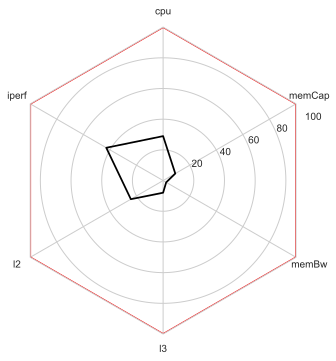

In [15]:
from radar import radar_graph

labels = radar_data['benchmark']
values = radar_data['tolerated_interference']

radar_graph(labels, values, [100]*len(values))